In [82]:
import numpy as np
import sys
import os
import fnmatch
sys.path.append('../')
import base as base
import path_analysis
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.interpolate import interp1d
from path_analysis import bootstrap
from scipy.stats import ttest_ind

## Modified functions from path_analysis

In [80]:
# Changes - discard trials that are too short - return None if trajectory was too short for time window

def straightness_over_time(trial_trajectory, time_window=2):

    straightness = []

    def _straight_line(start, end, length):

        _x = np.linspace(start[0], end[0], length)
        _y = np.linspace(start[1], end[1], length)

        return np.vstack([_x, _y]).T

    def _straight_length(start, end):

        return np.sqrt(np.sum((start - end)**2))

    def travel_distance(traj):
        return np.cumsum(np.sqrt(np.sum((traj[1:] - traj[:-1])**2,
                                        axis=1)))[-1]

    time = trial_trajectory[:, 0]


    time_after = np.cumsum(np.flip(time[1:] - time[:-1]))
    trajectory_ = np.flip(trial_trajectory[:, 1:3, ],
                            axis=0)

    if time_window is None:
        end_ind = -1
        trial_trajectory = trajectory_[:end_ind]
    elif time_after[-1] > time_window:
        end_ind = np.where(time_after > time_window)[0][0]
        trial_trajectory = trajectory_[:end_ind]
    else:
        print('Time window exceeds the length of trajectory for this trial. Straightness will not be computed.')
        return None, None, None

    for i in range(len(trial_trajectory) - 2):
        straight_length = _straight_length(trial_trajectory[i + 1],
                                           trial_trajectory[0])
        trajectory_displacement = travel_distance(trial_trajectory[:i + 2])

        straightness.append(straight_length / trajectory_displacement)

    return np.flip(straightness), (trial_trajectory[0],
                          trial_trajectory[-1]), trial_trajectory

## Single session example

In [4]:
root = '/mnt/c/Users/megla/OneDrive/Documents/TUM/RatAnalysis/Multiple_trial_analysis/Data/Raw/FS10/BPositions_FS10_20211006-154014'
tag = '20211006-154014'

In [6]:
FS10_one = base.BeaconPosition(root, tag, has_beacon=True, has_metadata=True)
FS10_one.metadata

,Recording started on,Computer time was,ITI_time,time_in_cylinder,movement_collection_time,animal_ID,background_color,circle,position_change,light_off,...,recording lenght,high pellets,high_time_in_cylinder,invisible_time,invisible_count,invisible_list,Animal jumped,Recording_started_motive,Recording_timestamp_motive,Day
1,2021-10-06 15:40:14,1633527614.36,1.5,1.5,0.01,FS10,000,0.075,1000,200,...,1814.625,20,0.5,60,0,[],-1,0,0.0,156


In [7]:
# Number of trials in this session
print(len(FS10_one.trial_list))

27


Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.


/tmp/ipykernel_849/1641021838.py:44: RuntimeWarning: invalid value encountered in double_scalars
  straightness.append(straight_length / trajectory_displacement)


Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.


/tmp/ipykernel_849/4012894967.py:42: RuntimeWarning: Mean of empty slice
  average_invis = np.nanmean(np.array(invisible),axis=0)


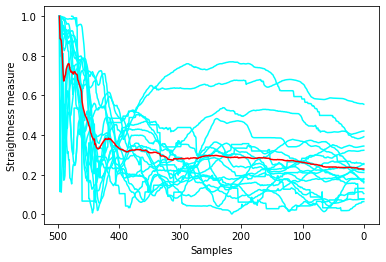

In [280]:
# This example has only visible trials
WIN_SIZE = 10 # Take 3 s segments

# Get the length of the straightness outputs
tmp_straightness, _, _ = straightness_over_time(FS10_one.trial_list[0], time_window=WIN_SIZE)

trial_num = len(FS10_one.trial_list[:])

# Initialize storing the trials by visible/invsible
# visible=np.nan*np.ones((len(tmp_straightness),trial_num)) # NaNs in shape (3 seconds = 148 samples, num_trials)
# invisible=np.nan*np.ones((len(tmp_straightness),trial_num)) # NaNs in shape (3 seconds = 148 samples, num_trials)

visible=[]
invisible=[]

# Loop through all trials
for i in range(len(FS10_one.trial_list)):
    
    # Returns (straightness metric, (start & end of trajectory), trajectory)
    straightness_metric, trajectory_pts, trajectory = \
    straightness_over_time(FS10_one.trial_list[i], time_window=WIN_SIZE)
    
    if straightness_metric is None: 
        continue
        
    else:

        # If successful invisible, store the straightness measure
        if FS10_one.trial_visible[i]:
            plt.plot(straightness_metric)
#             invisible[:,i] = straightness_metric
            invisible.append(straightness_metric)

        # Otherwise if visible, store the straightness measure
        else:
            plt.plot(straightness_metric, c='cyan')
#             visible[:,i] = straightness_metric
            visible.append(straightness_metric)
    
    
average_vis = np.nanmean(np.array(visible),axis=0)
average_invis = np.nanmean(np.array(invisible),axis=0)

plt.plot(average_vis, c='red')
plt.plot(average_invis, c='black')
plt.xlabel('Samples')
plt.ylabel('Straightness measure')
plt.gca().invert_xaxis()

## Now do the same for all sessions for FS10

In [16]:
root = '/mnt/c/Users/megla/OneDrive/Documents/TUM/RatAnalysis/Multiple_trial_analysis/Data/Raw/FS10/'
tags = [tag.split('_')[-1] for tag in os.listdir(root)]
ind_roots = [os.path.join(root, 'BPositions_FS10_' + tag) for tag in tags]

In [18]:
FS10 = base.MultiDaysBeaconPosition(ind_roots, tags, has_beacon=True, has_metadata=True)

/home/mlane/anaconda3/envs/ratanalysis/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [57]:
# Num sessions? 
num_sessions = len(FS10.trial_list)
print(f'Num sessions: {num_sessions}')

# Count the total number of trials
c = 0
for i in range(len(FS10.trial_list)): 
    for j in range(len(FS10.trial_list[i])): 
        c += 1

num_trials = c

print(f'Total number of trials: {num_trials}')

Num sessions: 15
Total number of trials: 731


In [249]:
# Now loop through all the sessions and trials and store them all together

WIN_SIZE = 10 # Take 3 s segments

# Initialize storing the trials by visible/invsible
visible = [] 
invisible = [] 

# Loop through all sessions and trials

for i, session in enumerate(FS10.trial_list): 
    for j, trial in enumerate(session): 
        
        straightness_metric, _, _ = straightness_over_time(trial, time_window=WIN_SIZE)
        
        if straightness_metric is None: 
            continue
        
        else: 
            # If successful invisible, store the straightness measure
            if FS10.trial_visible[i][j] == 1.:
                invisible.append(straightness_metric)

            # Otherwise if visible, store the straightness measure
            elif FS10.trial_visible[i][j] == 0.:
                visible.append(straightness_metric)

Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.


/tmp/ipykernel_849/1641021838.py:44: RuntimeWarning: invalid value encountered in double_scalars
  straightness.append(straight_length / trajectory_displacement)


Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajec

Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajectory for this trial. Straightness will not be computed.
Time window exceeds the length of trajec

In [229]:
# Double check the number of successful invisible trials stored in the metadata
trial_visible_bool = FS10.trial_visible

invis_count = 0
for session_num in range(num_sessions): 
    
    visibility = trial_visible_bool[session_num]
    num_successful_invis = np.sum(visibility == 1.0)
    
    invis_count += num_successful_invis

print(invis_count)

19


In [250]:
# Check the number of (successful) trials being averaged for invisible and visible
print(np.array(visible).shape)
print(np.array(invisible).shape)

average_vis = np.nanmean(np.array(visible), axis=0)
average_invis = np.nanmean(np.array(invisible), axis=0)

(442, 498)
(10, 498)


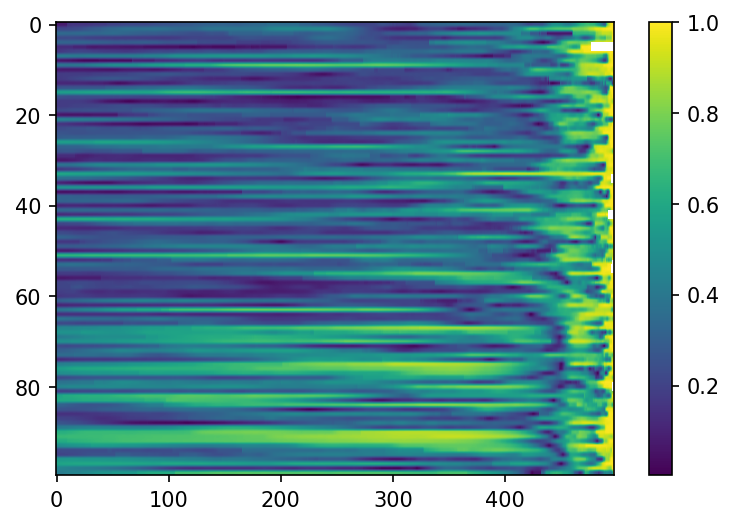

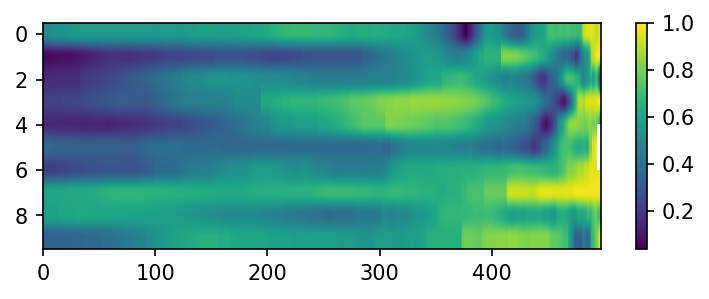

In [276]:
# Some visualizations
plt.figure(dpi=150, figsize=(6,4))
plt.imshow(np.array(visible)[:100,:], aspect='auto')
plt.colorbar()
plt.show()

# Some visualizations
plt.figure(dpi=150, figsize=(6,2))
plt.imshow(np.array(invisible), aspect='auto')
plt.colorbar()
plt.show()

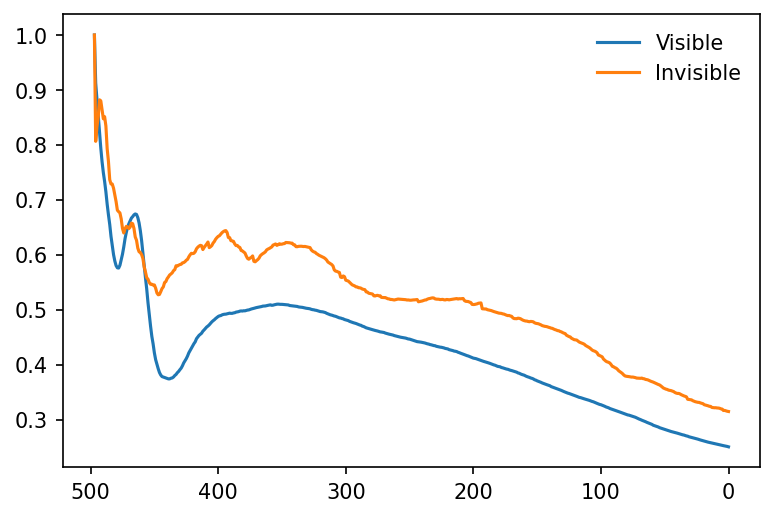

In [254]:
fig, ax = plt.subplots(dpi=150)
plt.plot(average_vis, label='Visible')
plt.plot(average_invis, label='Invisible')
plt.legend(frameon=False)
ax.invert_xaxis()
plt.show()

## Add bootstrapping random trajectories

In [49]:
print(root)

/mnt/c/Users/megla/OneDrive/Documents/TUM/RatAnalysis/Multiple_trial_analysis/Data/Raw/FS10/


In [255]:
# We want to sample a fixed number, say 50 trajectories from each session 
STRAIGHT_TYPE = 'sliding'
NUM_SAMPLES = 51
STEP_SIZE = 0.019999980926513672 # I got this from the first session, should rather check other sessions as well 
# or check & always take the most common one

# Store the bootstrapped samples here
full_boot = []

# In each case, we want to load the position file, resample the frame rate, and sample trajectories
# We have to loop through the sessions
for sess_folder in os.listdir(root): 
    
    pos_file = [os.path.join(root, sess_folder, f) \
                for f in os.listdir(os.path.join(root, sess_folder)) if 'position' in f][0]
    
    position = pd.read_csv(pos_file, sep=" ", header=None).to_numpy()
    pos_timeseries = position[:,0] # The first column is time 
    
    even_spaced_time = np.arange(pos_timeseries[0], pos_timeseries[-1], STEP_SIZE)
    
    interp_func_x = interp1d(pos_timeseries, position[:,1])
    interp_func_y = interp1d(pos_timeseries, position[:,3])

    interp_x = interp_func_x(even_spaced_time)
    interp_y = interp_func_y(even_spaced_time)
    
    # Now this should be the same shape as the original array, but resampled with constant fps
    interp_full = np.concatenate((np.expand_dims(even_spaced_time, axis=0), 
                              np.expand_dims(interp_x, axis=0), 
                              np.expand_dims(interp_y, axis=0))).T

    # This outputs an array of shape (NUM_SAMPLES, 148 = num time pts)
    full_boot.append(bootstrap(interp_full, time_window=WIN_SIZE, 
                                num_sampling=NUM_SAMPLES, 
                                straightness_type=STRAIGHT_TYPE))

/mnt/c/Users/megla/OneDrive/Documents/TUM/RatAnalysis/Multiple_trial_analysis/refactoring/demo_notebook/../path_analysis.py:89: RuntimeWarning: invalid value encountered in double_scalars
  straightness.append(straight_length / trajectory_displacement)


In [256]:
avg_boot_sessions = np.nanmean(np.array(full_boot), axis=0)
avg_boot_trials = np.nanmean(avg_boot_sessions, axis=0)

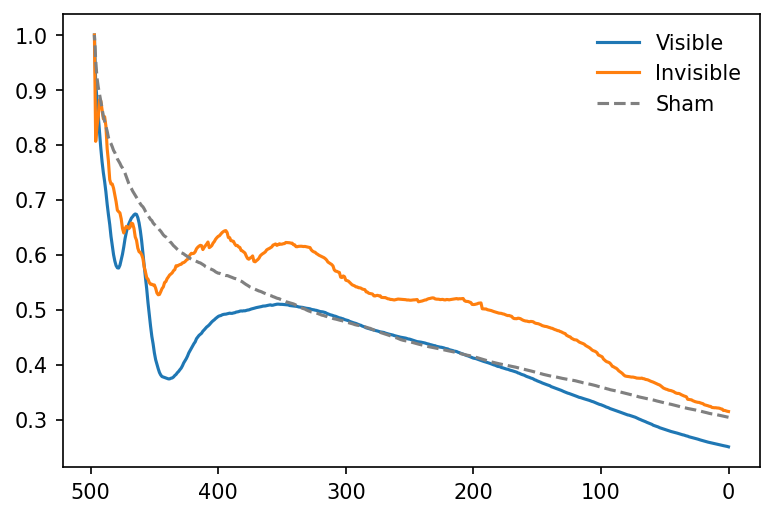

In [257]:
fig, ax = plt.subplots(dpi=150)
plt.plot(average_vis, label='Visible')
plt.plot(average_invis, label='Invisible')
plt.plot(avg_boot_trials, label='Sham', color='grey', linestyle='--')
plt.legend(frameon=False)
ax.invert_xaxis()
plt.show()

In [190]:
# We want to check the pvals on all of the timepoints and return the points that pass our significance threshold

def compute_pvals(real_data, sham_data, p_sig=0.05):
    
    ''' 
    Parameters
    
    real_data: Our straightness ratios for a set of invisble or visible trials; shape (ntrials, nsamples)
    sham_data: Bootstrapped data sampled from trajectories; shape (nbootstrapped, nsamples)
    p_sig: Our selected significance threshold
    
    Returns
    
    time_sig: array of values of timepoints (samples) where the mean straightness ratio passed the null hypothesis
        
    '''
    
    # Make sure both data arrays have the same number of samples (timepoints)
    assert real_data.shape[1] == sham_data.shape[1], "Ensure that your input data arrays the same number of samples!"
    
    num_samples = real_data.shape[1]
    sig_pts = []
    
    for i in range(num_samples): 
        
        tstat, pval = ttest_ind(real_data[:,i], sham_data[:,i], equal_var=False)
        if pval < p_sig: 
            sig_pts.append(i)
    
    return sig_pts

def get_sig_ranges(time_list):
    
    time_diffs = np.diff(time_list)
    change_idx = np.where(time_diffs > 1)[0]
    
    if len(change_idx) == 0: 
        print('Only one range')
        return time_list
    
    else: 
        print('Found multiple ranges')
        return change_idx

In [258]:
p_val = 0.05

vis_array = np.array(visible)
invis_array = np.array(invisible)
full_boot_arr = np.reshape(np.array(full_boot), (-1, vis_array.shape[1]))

sig_times_vis = compute_pvals(vis_array, full_boot_arr, p_val)
sig_times_invis = compute_pvals(invis_array, full_boot_arr, p_val)

In [259]:
vis_range = get_sig_ranges(sig_times_vis)
invis_range = get_sig_ranges(sig_times_invis)

Found multiple ranges
Found multiple ranges


In [260]:
print(sig_times_vis)
print(sig_times_invis)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,

## Plot for visible

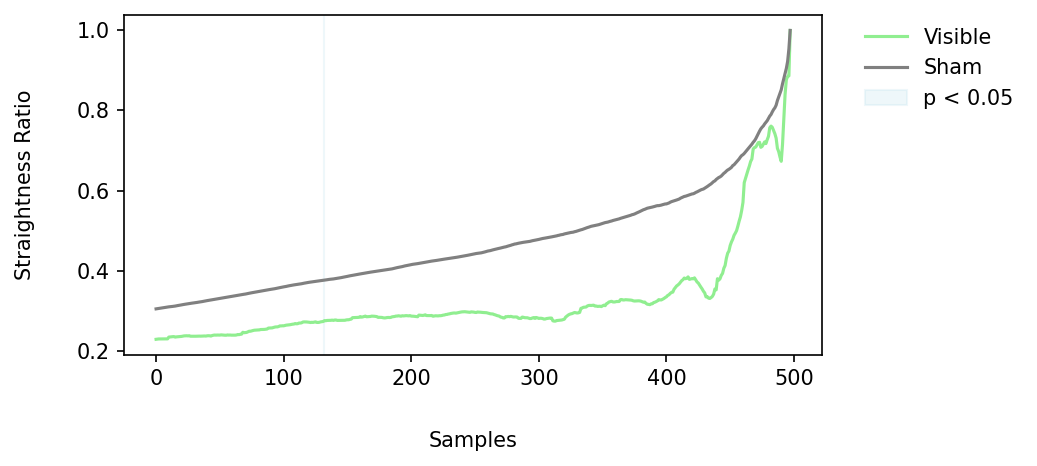

In [283]:
# Plot the straightness ratios again and shade the significant time points (this example for visible)
fig, ax = plt.subplots(dpi=150, figsize=(6,3))

plt.plot(average_vis, label='Visible', c='lightgreen')
plt.plot(avg_boot_trials, label='Sham', c= 'grey')

ax.axvspan(vis_range[0], vis_range[-1], alpha=0.2, color='lightblue', label='p < 0.05')

plt.ylabel('Straightness Ratio', labelpad=20)
plt.xlabel('Samples', labelpad=20)

plt.legend(frameon=False, fontsize=10, loc=[1.05, 0.7])

plt.show()

## Plot for invisible

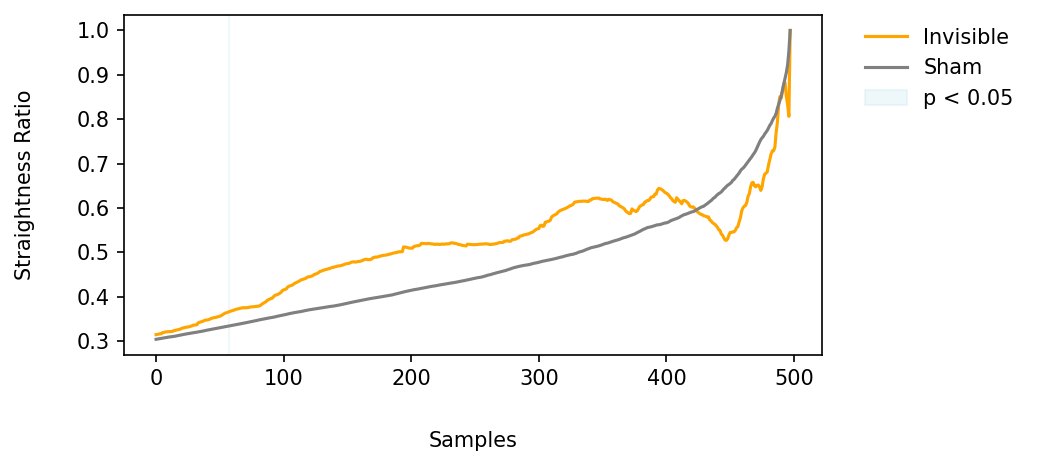

In [262]:
# Plot the straightness ratios again and shade the significant time points (this example for visible)
fig, ax = plt.subplots(dpi=150, figsize=(6,3))

plt.plot(average_invis, label='Invisible', c='orange')
plt.plot(avg_boot_trials, label='Sham', c= 'grey')

# ax.axvspan(sig_times_invis[0], sig_times_invis[invis_range[0]], alpha=0.2, color='lightblue', label='p < 0.05')
# ax.axvspan(sig_times_invis[invis_range[0]+1], sig_times_invis[invis_range[1]], alpha=0.2, color='lightblue')
# ax.axvspan(sig_times_invis[invis_range[1]+1], sig_times_invis[-1], alpha=0.2, color='lightblue')
ax.axvspan(invis_range[0], invis_range[-1], alpha=0.2, color='lightblue', label='p < 0.05')

plt.ylabel('Straightness Ratio', labelpad=20)
plt.xlabel('Samples', labelpad=20)

plt.legend(frameon=False, fontsize=10, loc=[1.05, 0.7])

plt.show()

## Try the trajectories for a different animal - FS11

In [290]:
root = '/mnt/c/Users/megla/OneDrive/Documents/TUM/RatAnalysis/Data/FS11/'
tags = [tag.split('_')[-1] for tag in os.listdir(root)]
ind_roots = [os.path.join(root, 'BPositions_FS11_' + tag) for tag in tags]

In [291]:
FS11 = base.MultiDaysBeaconPosition(ind_roots, tags, has_beacon=True, has_metadata=True)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# Now loop through all the sessions and trials and store them all together

WIN_SIZE = 10 # Take 3 s segments

# Initialize storing the trials by visible/invsible
visible_FS11 = [] 
invisible_FS11 = [] 

# Loop through all sessions and trials

for i, session in enumerate(FS11.trial_list): 
    for j, trial in enumerate(session): 
        
        straightness_metric, _, _ = straightness_over_time(trial, time_window=WIN_SIZE)
        
        if straightness_metric is None: 
            continue
        
        else: 
            # If successful invisible, store the straightness measure
            if FS11.trial_visible[i][j] == 1.:
                invisible_FS11.append(straightness_metric)

            # Otherwise if visible, store the straightness measure
            elif FS11.trial_visible[i][j] == 0.:
                visible_FS11.append(straightness_metric)

In [ ]:
# Check the number of (successful) trials being averaged for invisible and visible
print(np.array(visible).shape)
print(np.array(invisible).shape)

average_vis = np.nanmean(np.array(visible), axis=0)
average_invis = np.nanmean(np.array(invisible), axis=0)

In [ ]:
fig, ax = plt.subplots(dpi=150)
plt.plot(average_vis, label='Visible')
plt.plot(average_invis, label='Invisible')
plt.legend(frameon=False)
ax.invert_xaxis()
plt.show()